In [22]:
import sys
sys.path.append('/home/nick/workspace/zoo-aquifer')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import pymannkendall as mk
from sklearn import metrics
import seaborn as sns
from utils import viz

In [23]:
# Set notebook parameters
start_date = '1999-10-01'
end_date = '2023-09-30'

In [30]:
# Bring in data
df = pd.read_csv('../data/missoula_valley_wells_imputed_wells.csv')
df_raw = pd.read_csv('../data/missoula_valley_monitored_wells.csv', parse_dates=['time'], index_col='time')
df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
df_static = pd.read_csv('../data/static_variables.csv')
df_norm = pd.read_csv('../data/dynamic_variables_all_normalized.csv', index_col=0, parse_dates=True)
df_norm = df_norm[(df_norm.index >= start_date) & (df_norm.index <= end_date)]
df_miller = pd.read_csv('../data/ross_miller_data.csv')
df_pop = pd.read_csv('../data/mso_pop_year.csv', index_col=0)
df_err = pd.read_csv('../data/imputation_error_stats.csv', index_col=0)

# Format streamflow data
q = df[['time', 'Q']]
q.set_index('time', inplace=True)
q.index = pd.to_datetime(q.index)
q_norm = df_norm['Q']

# Format groundwater data
df_norm['gw_avg'] = df_norm.iloc[:, 2:].mean(axis=1)
df_raw = -df_raw
depth_cols = [i for i in df.columns if not i in ['time', 'Q', 'pumping_rate']]
for col in depth_cols:
    df[col] *= -1

# Melt groundwater data
df_melt = df.drop(columns='Q').melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])
df_melt.rename(columns={'variable':'gwic_id'}, inplace=True)

## Introduction

The Missoula Aquifer is one of only 64 designated sole source aquifers in the United States.^[https://www.epa.gov/dwssa] As such, it supplies over 75,000 residents, plus businesses, with potable groundwater. Historically, the aquifer has shown incredible resilience to drought and increases in population within the Missoula valley area. There have been no long-term signs of depletion in any of the 27 monitoring wells within the aquifer. This is likely due to the very high transmissivity rates, location within the Clark Fork and Bitterroot watersheds, reasonable historical growth rates of the surrounding population, and only mild changes in historical climate [@whitlock2017MontanaClimate2017]. 

Due to the unconfined nature of the aquifer and the high transmissivity rates of the substrate, the upstream inflows, and downstream outflows, of the aquifer are largely driven by the Clark Fork River [@tallmanSourcesWaterCaptured2005; @millerNumericalFlowModel1991]. In fact, according to previous studies, the Clark Fork River provides over 80% of the annual aquifer recharge (@tbl-miller). Thus, it is fair to say that any long-term changes in streamflow will likely have far reaching impacts to the recharge and overall sustainability of the aquifer.     


In [25]:
#| label: tbl-miller
#| tbl-cap: Missoula aquifer source of average annual inflow according to 
#|   @millerNumericalFlowModel1991.

total = df_miller['Inflow (af/yr)'].iloc[-1]
df_miller['Percent of Total'] = df_miller.apply(lambda row: round(100*row['Inflow (af/yr)']/total, 2).astype(str), axis=1)
# df_miller.loc[3, 'Percent of Total'] = np.nan
df_miller.style.hide()

Source,Inflow (af/yr),Percent of Total
Clark Fork River,192000,82.76
Creek Drainages and Tertiary Hillsides,19000,8.19
Lateral Underflow (Bitterroot and Hellgate),21000,9.05
Total,232000,100.0


Climate change is expected to impact the Clark Fork River in numerous ways over the coming decades [@whitlock2017MontanaClimate2017]. Average annual discharge is projected to increase, although there is large uncertainty around this projection. With higher confidence, there is expected to be a shift in the timing of peak runoff leading towards lower base flows in the summer months. In addition, when future drought occurs, the severity is expected to increase, resulting in extended periods of drier than normal conditions [@montanadnrcMontanaDroughtManagement2023]. These projected changes will undoubtedly affect the groundwater of the Missoula Aquifer and impact local extractions for drinking water, irrigation, and industrial purposes.  

From 2000 to 2024 the Missoula area population has increased from 57,000 to 78,000.^[https://www.census.gov/programs-surveys/popest.html] Using the standard assumption of 160 gallons/day/person, we estimate that water use has increased from 10,200 af to 14,100 af over this same time period (@fig-water-use). Consequently, according to the Montana Ground Water Information Center^[https://mbmggwic.mtech.edu] there are currently over 3,500 wells listed in the Missoula area. Of those wells, 247 are labeled as "public water," which includes the City of Missoula's water supply (@fig-extract-map). Population in the Missoula area is expected to continue to increase over the next several decades^[Correspondence with Marc Hendrickson on 2/13/2024] likely leading to more wells and higher extraction rates to sustain this growth. In spite of the historical resilience of the aquifer to these changes, many questions still remain unanswered.  

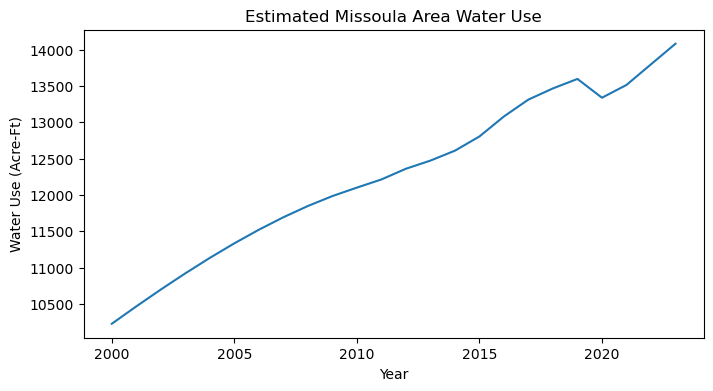

In [26]:
#| label: fig-water-use
#| fig-cap: Estimated water use based on the U.S. Census population data within the Missoula area
#|  and an average consumption of 160 gallons/day/person.

df_pop['WatUse_af'].plot(figsize=(8, 4))
plt.xlabel('Year')
plt.ylabel('Water Use (Acre-Ft)')
plt.title('Estimated Missoula Area Water Use')
plt.show()

![All extraction wells within the Missoula area (eastern Missoula Aquifer).](./images/mso_map_of_all_wells.jpg){#fig-extract-map}

What if climate change and population growth converge to maximize stress on the aquifer? While these kinds of scenarios are not determined, they are all well within the realm of realistic possibilities, perhaps even probable. Given the overall resilience that we have seen in the past, it is possible that the aquifer can withstand these stressors and continue to deliver clean and plentiful potable water to the Missoula community in perpetuity. However, to date, no one has studied these different scenarios to make sure that our future water resources are protected. In this analysis, we first evaluate the long-term historial trends in Clark Fork River discharge, City of Missoula pumping rates, and Missoula Aquifer water table depth. In subsequent analyses (not inlcuded in this preliminary report) we plan to specifically study the impacts of plausible future scenarios on the Aquifer to identify critical tipping points and mitigation strategies.  

## Methods

### Study Area

The study area includes the greater Missoula area. Within this region there are 16 monitoring wells used in the analysis (@fig-site-map). 

![The study site including the 16 monitoring wells used in the analysis.](./images/site_map.png){#fig-site-map}

### Data Imputation (Gap Filling)

The historical groundwater measurements from the 16 monitoring wells used in our analyses, were taken sporadically and inconsistently over the study time period (@fig-gw-imputation). Therefore, in order to compare across all sites we needed to fill the data gaps and resample to monthly average values. We used a two-step approach to gap fill the data. In the first step we identified the two wells with close to continuous data (e.g. 151189 and 151190; @fig-gw-imputation). We then used seasonal trend decomposition using LOESS (STL; @clevelandSTLSeasonaltrendDecomposition1990) to fill in the few missing data points of those two wells. In the second step, we developed a multiple linear regression (MLR) model for each well using the two complete wells plus the day of year (i.e. last day of the month) as independent, predictor variables. We used this MLR model to impute data into the gaps of each well independently to create consistent monthly data across all water-years (2000-2023) in each monitoring well used in the study. We tested several other methods including linear interpolation, time-based interpolation, MLR using Clark Fork River flows, and STL by iterating the method 100 times and leaving out 5 known data points to later predict with the model. The multiple linear regression imputation method using the two complete wells and day of year proved to have the best error statistics across the all metrics (MAE, MSE, RMSE, MAPE, and R-squared; @tbl-error-stats)^[https://vitalflux.com/mse-vs-rmse-vs-mae-vs-mape-vs-r-squared-when-to-use]. 

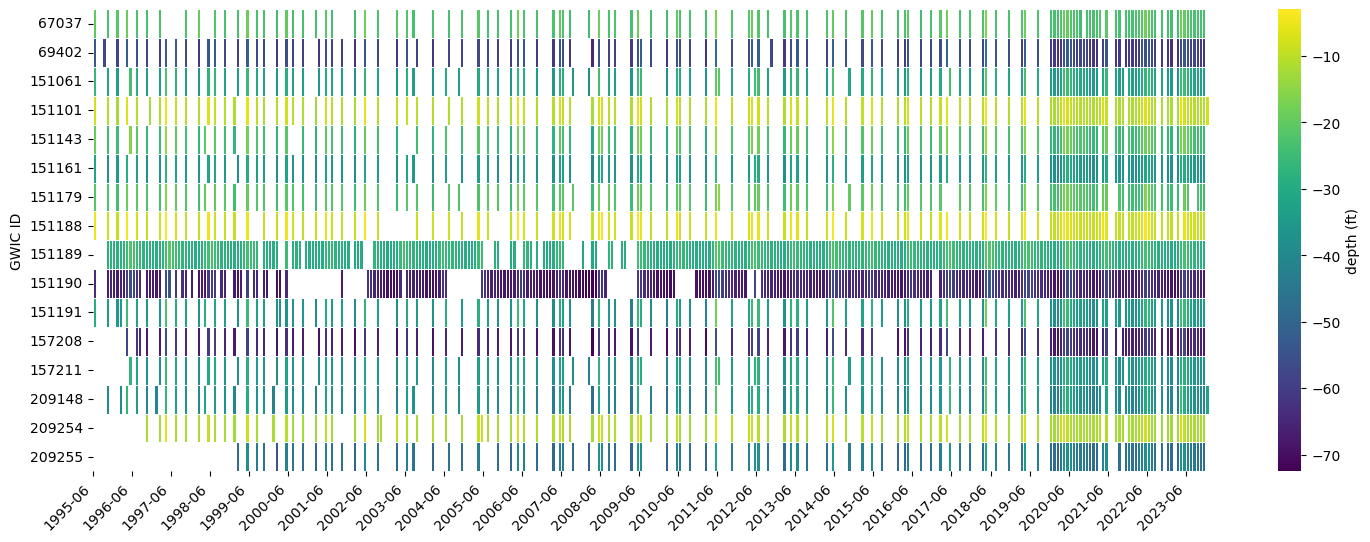

In [27]:
#| label: fig-gw-imputation
#| fig-cap: The groundwater monitoring sampling dates for each well before gap filling. 
#|  The y-axis is the MT GWIC number of the well. The vertical lines represent the date 
#|  sampled for each well. Color represents the value of the measurement (i.e. depth below
#|  ground). Since 2020, nearly all the wells have fairly dense records, missing few 
#|  months (white areas). Only two wells (151189 & 151190) have fairly full records (data
#|  for each month of the year). The others have sparse data in the beginning of the record. 
#|  We used multiple linear regression imputation, to fill these gaps based on relationships
#|  between water table depth and the day of the year and the two wells with the most 
#|  complete data. This resulted in a continuous monthly dataset from Oct 1999 through Sep 
#|  2023. 

fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(df_raw.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = df_raw.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_ylabel('GWIC ID')
ax.set_xlabel('')
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

In [ ]:
#| label: tbl-error-stats
#| tbl-cap: Error statistics from the data imputation methods tested. For this study
#|  we used the STL Decomposition to fill data in the two most complete wells and then
#|  used the Well (MLR) Regression method using those two wells and day of year to
#|  build models for each well and use those models to gill gaps in the data record.

df_err.round(4)

,MAE,MSE,RMSE,MAPE,R^2
Linear Interpolation,2.4923,13.8497,3.7215,10.5845,0.9556
STL Decomposition,1.3017,3.9748,1.9937,5.4697,0.9873
Time Interpolation,2.4703,13.7026,3.7017,10.5757,0.9563
Q and DOY Regression,1.6086,4.9560,2.2262,6.1077,0.9843
Well Regression,0.9365,1.9474,1.3955,4.5326,0.9929


## Historical Analysis

### Clark Fork River

The Clark Fork River serves as the main source for aquifer recharge in the Missoula Valley [@tallmanSourcesWaterCaptured2005]. While other inputs exist, we focus almost exclusively on the Clark Fork due to the overall magnitude relative to other inputs. A seasonal decomposition using LOESS [@clevelandSTLSeasonaltrendDecomposition1990] shows that there has been a consistent increasing trend in monthly average flows over the study period (2000-2023; @fig-cfr-stl). Change was steepest through 2011 and then flattened through the rest of the record. In addition, as expected, there is a strong seasonality component with peak flows coming in late spring and baseflows in late summer and early fall. The magnitude of seasonality is increasing, with the peaks getting higher and the troughs getting lower -- suggesting an increasing trend in interannual variability through time. 

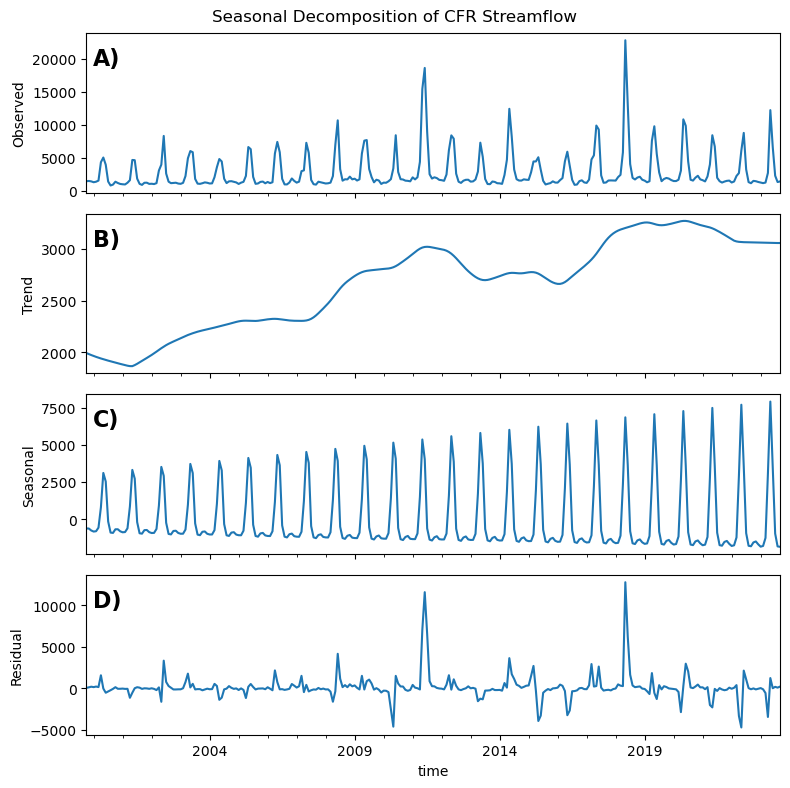

In [7]:
#| label: fig-cfr-stl
#| fig-cap: 
#|  Seasonal decomposition of the Clark Fork River monthly streamflows. The top 
#|  panel (A) is the full stremflow signal--the mean daily discharge for each month
#|  from 2000 to 2023. The second panel (B) shows the trend over the time period with
#|  other signals removed. The third panel (C) is the seasonal signal without the trend.
#|  And the bottom panel (D) is the remainder of the signal no catpured by the trend and 
#|  seasonal components.

stl_q = STL(q, seasonal=25, period=12, robust=True, trend=39) #39
res_q = stl_q.fit()
# res_q = seasonal_decompose(q, period=12)
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
res_q.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
ax[0].text (.01, 0.8, 'A)', transform=ax[0].transAxes, fontsize=16, fontweight='bold')
res_q.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
ax[1].text (.01, 0.8, 'B)', transform=ax[1].transAxes, fontsize=16, fontweight='bold')
res_q.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
ax[2].text (.01, 0.8, 'C)', transform=ax[2].transAxes, fontsize=16, fontweight='bold')
res_q.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
ax[3].text (.01, 0.8, 'D)', transform=ax[3].transAxes, fontsize=16, fontweight='bold')
fig.tight_layout()
fig.suptitle('Seasonal Decomposition of CFR Streamflow')
fig.subplots_adjust(top=0.95)
plt.show()



We further investigate the trend of the Clark Fork River flows using a Mann-Kendall statistical significance test [@mannNonparametricTestsTrend1945; @kendallRankCorrelationMethods1975], which avoids assumptions of normality and independence. The results indicate a statistically significant ($p<0.05$) increasing trend of 24 cfs/month. We further break down the trend analysis into seasons: winter (December, January, February), spring (March, April, May), summer (June, July, August), and fall (September, October, November) (@fig-cfr-seas-trends). All four seasons have increasing trends, although the summer season's trend is not statistically significant at the $p<0.05$ level. The spring runoff trend is by far the strongest, representing a slope 113 cfs/season. Spring is the season where most of the recharge from the Clark Fork River to the Missoula Aquifer occurs [@tallmanSourcesWaterCaptured2005].

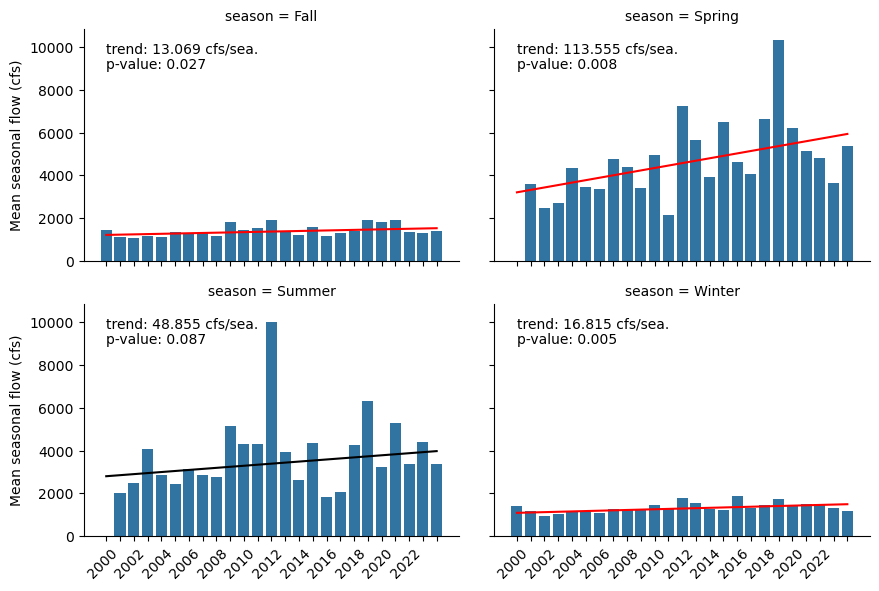

In [8]:
#| label: fig-cfr-seas-trends
#| fig-cap: Seasonal trends for Clark Fork River flows. Red line indicate a 
#|  statistically significant ($p<0.05$) trend; black line indicates a non-
#|  statistically significant ($>=0.05) trend. The amount of the trend in
#|  cfs/season and p-values are shown on each panel. 

# Create the FacetGrid plot
q = q.assign(season = q.index.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}))

q_seas = q.groupby('season').resample('Y')['Q'].mean().reset_index(['season'])
q_seas.index = q_seas.index.strftime('%Y')
g = sns.FacetGrid(q_seas.reset_index(), col='season', col_wrap=2, sharey=True, sharex=True, height=3, aspect=1.5)
g.map(sns.barplot, 'time','Q', order=q_seas.index.unique())
g.set_ylabels('Mean seasonal flow (cfs)')

# Look for trends in seasons
mk_seas_w = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Winter').dropna())
mk_seas_sp = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Spring').dropna())
mk_seas_su = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Summer').dropna())
mk_seas_f = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Fall').dropna())

pvals = [mk_seas_f.p, mk_seas_sp.p, mk_seas_su.p, mk_seas_w.p]
ms = [mk_seas_f.slope, mk_seas_sp.slope, mk_seas_su.slope, mk_seas_w.slope]
x1 = 0
x2 = 24 
pts1 = [[x1, x2], 
        [x1, x2], 
        [x1, x2], 
        [x1, x2]] 

pts2 = [[mk_seas_f.slope*x1 + mk_seas_f.intercept, mk_seas_f.slope*x2 + mk_seas_f.intercept], 
        [mk_seas_sp.slope*x1 + mk_seas_sp.intercept, mk_seas_sp.slope*x2 + mk_seas_sp.intercept], 
        [mk_seas_su.slope*x1 + mk_seas_su.intercept, mk_seas_su.slope*x2 + mk_seas_su.intercept], 
        [mk_seas_w.slope*x1 + mk_seas_w.intercept, mk_seas_w.slope*x2 + mk_seas_w.intercept]] 

# Rotate the x-tick labels, add text, and trendlines on all subplots
for i, ax in enumerate(g.axes.flat):
    m = f"trend: {ms[i]:.3f} cfs/sea."
    pval = f"p-value: {pvals[i]:.3f}"
    if pvals[i] > 0.05:
        c = 'black'
    elif pvals[i] <= 0.05:
        c = 'red'
    ax.text(0, 9000, pval)
    ax.text(0, 9700, m)
    ax.plot(pts1[i], pts2[i], color=c)
    # ax.text(1, 8000, str(i))
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)

plt.show()

### Groundwater Table Depth

We evaluated trends in groundwater table depth for each of the 16 wells within the study site using the Mann-Kendall test. All 16 wells have statistically significant increasing trends and strong seasonality, similar to the Clark Fork River streamflow (@fig-gw-trends). On average, there has been approximately a 1.9 foot increase in elevation of the water table over the period of record. Trends and timeseries data are very similar across all the sites, supporting previous studies showing high transmissivity throughout the aquifer [@tallmanSourcesWaterCaptured2005; @millerNumericalFlowModel1991].  

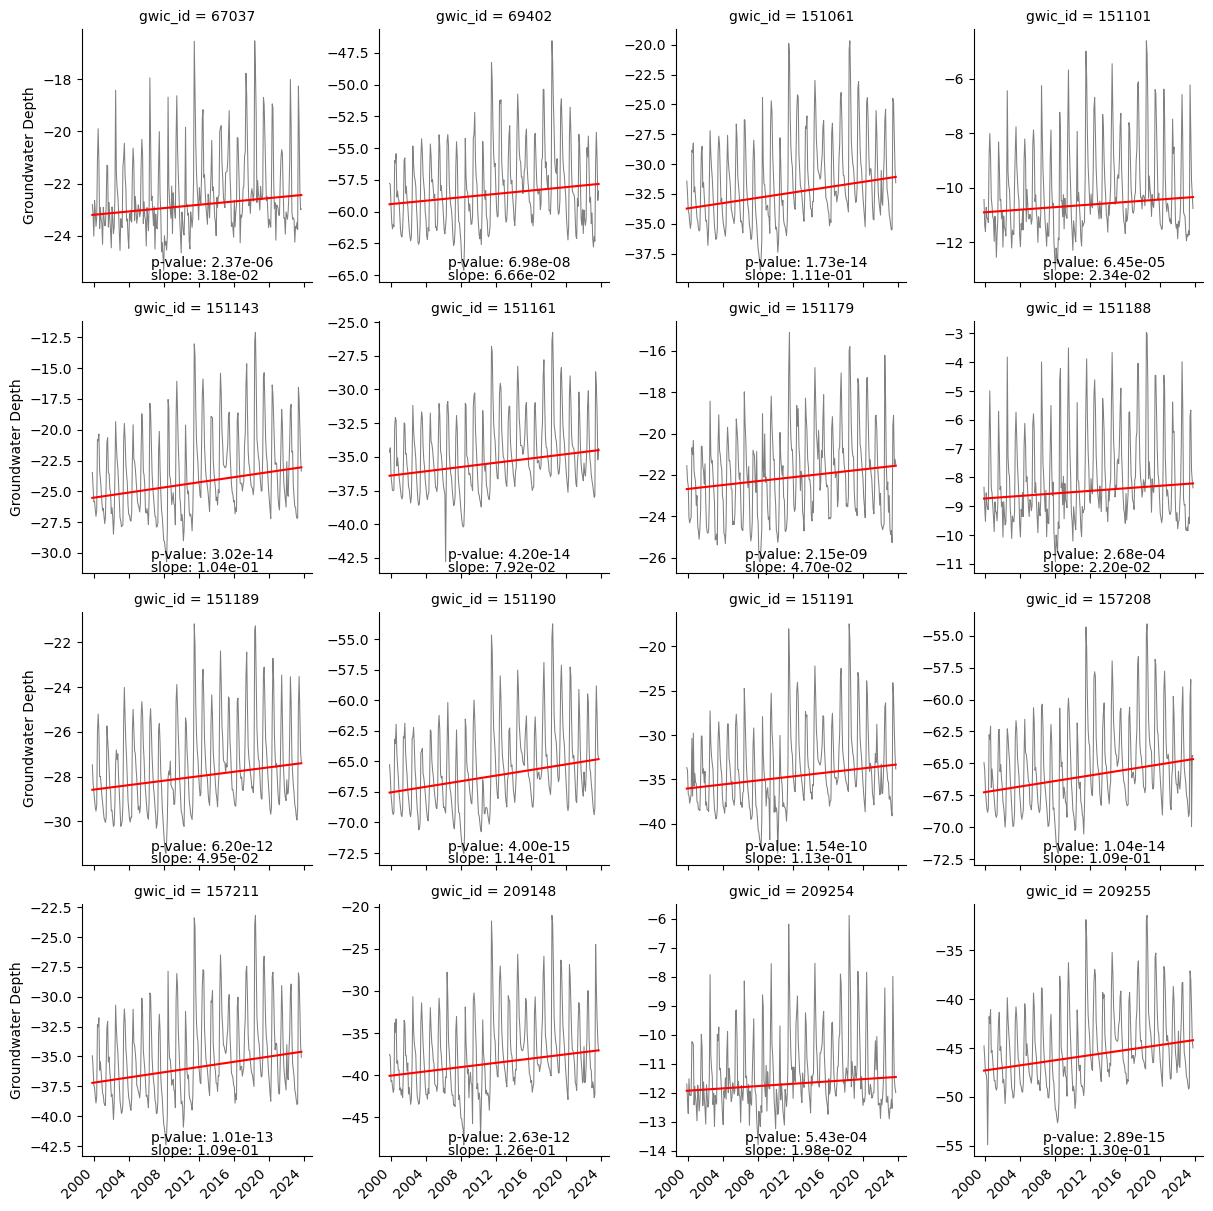

In [9]:
#| label: fig-gw-trends
#| fig-cap: Trends in groundwater depth for the 16 wells within the study area. Red
#|  line indicates a statistically significant trend ($p<0.05$). 

# Calculate trends and p-values and add to the DataFrame
df_trend = df_melt.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('gwic_id').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='gwic_id')

# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)
g.set_ylabels('Groundwater Depth')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

Additionally, we calculated the 10th, 50th, and 90th quantile regression lines to show trends in lower, median, and upper groundwater values, respectively (@fig-gw-quantreg). The changes in the 10th and 90th quantiles can be thought of as changes in the late Summer and early Spring since those are the times of year when groundwater elevations are at a minimum and maximum, respectively. The results show strong increasing trends in the 90th quantile, suggesting that increases in peak recharge events in the Spring are largely driving the overall trend in the groundwater. Median and lower quantiles show less of an increasing trend. The difference in trends between the 90th and 10th percentile also suggest an overall increase in interannual variability throughout the time period, similar to the seasonality trend in the Clark Fork River seasonal decomposition analysis (@fig-cfr-stl). 

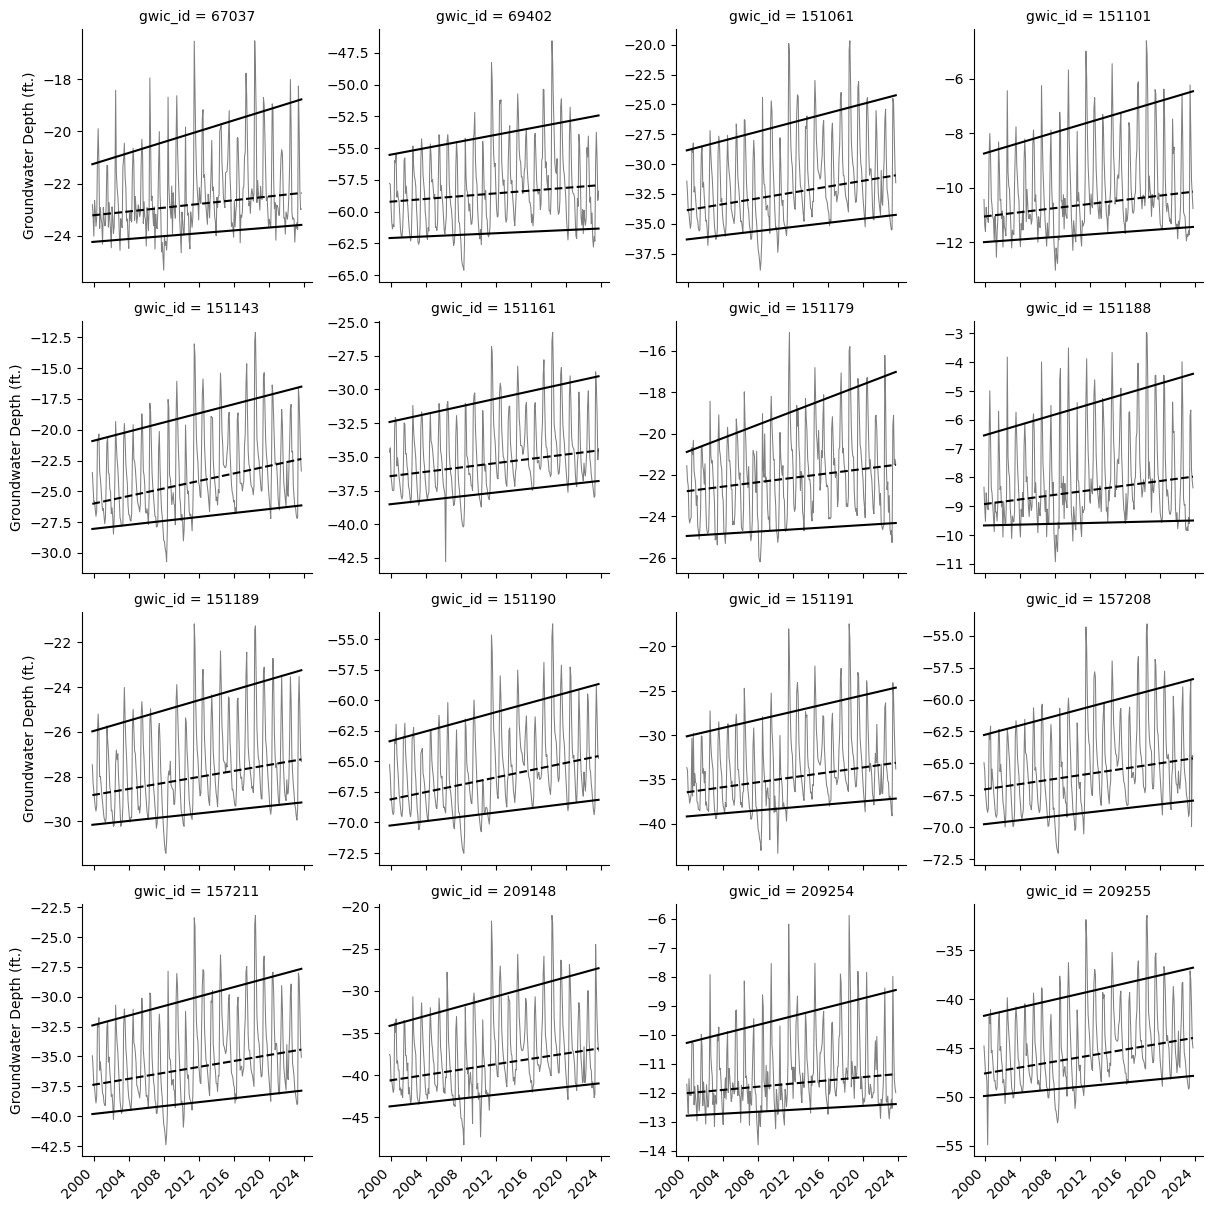

In [10]:
#| label: fig-gw-quantreg
#| fig-cap: Upper (90th percentile), median (50th percentile, dashed), and lower 
#|  (10th percentile) trends in groundwater data. The 90th percentile trends
#|  are consistently the largest, suggesting increases in peak recharge events 
#|  and interannual variability.

# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_quantreg)
g.set_ylabels('Groundwater Depth (ft.)')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

In [10]:
# #| label: fig-gw-quantreg-lower
# #| fig-cap: Trends in lower (10th percentile) groundwater depths. The red markers indicate 
# #|  decreasing trends. The blue markers indicate increasing trends. 

# # Calculate slope of quantile regression lines
# gwicids = df_trend['gwic_id'].unique()
# df_quantreg = pd.DataFrame(columns=['gwicid', 'quantreg_m1', 'quantreg_m9', 'quantreg_m5'])
# for gwicid in gwicids:
#     data = df_trend[df_trend['gwic_id'] == gwicid]
#     q1, q9, q5 = viz.plot_data_and_quantreg(data, 'blue', quants=[0.1, 0.9], plot=False)
#     m1, m9, m5 = q1.params.x, q9.params.x, q5.params.x
#     new_data = [gwicid, m1, m9, m5]
#     df_quantreg.loc[len(df_quantreg)] = new_data

# # Add trends to spatial dataframe
# trends.index = trends.index.astype('int64')
# df_stat = df_static.merge(trends, left_on='gwicid', right_index=True)
# df_stat['gwicid'] = df_stat['gwicid'].astype(str)
# df_stat = df_stat.merge(df_quantreg, left_on='gwicid', right_on='gwicid') 

# # Convert to GeoDataFrame
# df_stat['geometry'] = [Point(xy) for xy in zip(df_stat.longitude, df_stat.latitude)]
# gdf_stat = gpd.GeoDataFrame(df_stat, geometry='geometry', crs='EPSG:4326')

# # Plot map of slope values
# ax = gdf_stat.plot(figsize=(12, 6), 
#                    column='quantreg_m1', 
#                    cmap='coolwarm_r', 
#                    legend=True, 
#                    edgecolor='black',
#                    marker='^',
#                    scheme='User_Defined',
#                    classification_kwds=dict(bins=[0]),
#                    s=100)

# # Change legend text
# leg_text = ['Decreasing', 'Increasing']
# leg = ax.get_legend()
# for i, l in enumerate(leg.get_texts()):
#     l.set_text(leg_text[i])

# ctx.add_basemap(ax, 
#                 crs=gdf_stat.crs, 
#                 source=ctx.providers.CartoDB.Positron,
#                 zoom=12)
# # cbar = ax.get_figure().get_axes()[1]
# # cbar.set_ylabel('slope (ft/mo)')
# ax.set_title('Groundwater trends in lower (10th %) water table depth in Missoula Valley wells')
# # ax.set_axis_off()
# plt.show()

### Groundwater Withdrawals 

To understand the relationship and patterns of groundwater levels, Clark Fork streamflow, and Missoula City pumping rates, we normalize all monthly values to be between zero and one (@fig-norm-ts). We average the normalized groundwater depths across all wells to get a representative groundwater signal to compare to river flows and pumping rates. The signals are remarkably aligned in their seasonality. Essentially, the City is increasing their pumping at the same time streamflow, and thus groundwater, are at their maximum. This is an opportunitistic situation and one that should be monitored closely if streamflow timing were to shift due to changes in snowpack runoff, as projected by climate change studies [@whitlock2017MontanaClimate2017]. The main difference in these three signals is the lagged decrease in groundwater levels in comparison to the river and pumping rate. Groundwater tends to drop much slower than the two independent variables, suggesting there is some storage effect in the unconfined aquifer. This may help to mitigate some future shifts in peak streamflow if they were to occur. 

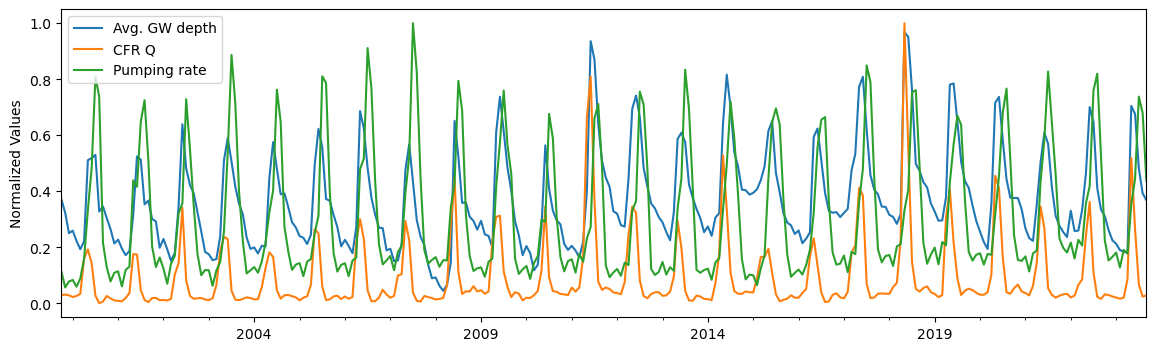

In [11]:
#| label: fig-norm-ts
#| fig-cap: Normalized timeseries values for average groundwater depth (blue),
#|  Clark Fork River streamflow (orange), and Missoula City pumping rates
#|  (green). All values are monthly averages. 

# Plot normalized time seris of gw, q, and pumping rate   
plt.figure(figsize=(14, 4))
df_norm['gw_avg'].plot(label='Avg. GW depth')
df_norm['Q'].plot(label='CFR Q')
df_norm['pumping_rate'].plot(label='Pumping rate')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()

We perform a seasonal decomposition analysis using LOESS on the City pumping rate time series [@clevelandSTLSeasonaltrendDecomposition1990]. Similar to the Clark Fork River flows and groundwater level, the City pumping rate has a slight increasing trend and strong seasonality over the study time period (@fig-pumping-stl). While the overall trend is increasing, there are three smaller trends that are distinct across the time period. From 2000 to 2008 the pumping rate increases, then from 2009 to 2015 the pumping rate decreases, followed by another strong increasing trend from 2016 to 2023. The effects of these inflection points in the pumping rate trends are explored in further detail later in this section.

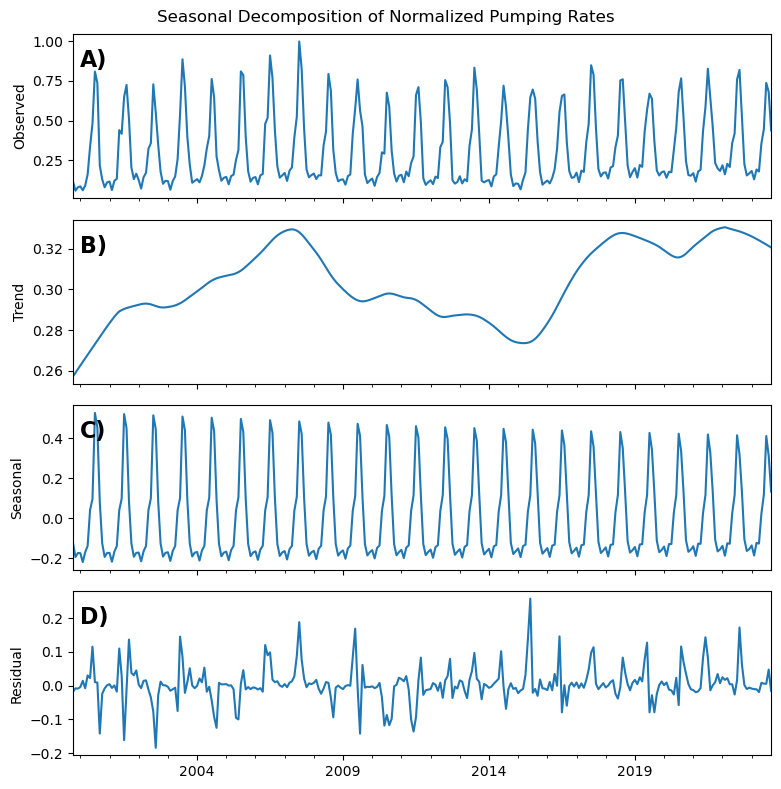

In [16]:
#| label: fig-pumping-stl
#| fig-cap: The seasonal decomposition using LOESS of the City of Missoula
#|  pumping rates. Panel A) is the combined signal, panel B) is the trend,
#|  panel C) is the seasonality, and panel D) is the residual after trend 
#|  and seasonality are removed.

res_pr = STL(df_norm['pumping_rate'], seasonal=25, period=12, trend=39, robust=True).fit()
# res_pr = seasonal_decompose(df_norm['pumping_rate'], period=12)
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
res_pr.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
ax[0].text (.01, 0.8, 'A)', transform=ax[0].transAxes, fontsize=16, fontweight='bold')
res_pr.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
ax[1].text (.01, 0.8, 'B)', transform=ax[1].transAxes, fontsize=16, fontweight='bold')
res_pr.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
ax[2].text (.01, 0.8, 'C)', transform=ax[2].transAxes, fontsize=16, fontweight='bold')
res_pr.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
ax[3].text (.01, 0.8, 'D)', transform=ax[3].transAxes, fontsize=16, fontweight='bold')
fig.tight_layout()
fig.suptitle('Seasonal Decomposition of Normalized Pumping Rates')
fig.subplots_adjust(top=0.95)
plt.show()

The most recent 10 water-years (2014-2023) provide an interesting case study. Over this time period, pumping rates have strongly increased (@fig-pumping-stl B) and river flows have remained around the same (slight increase; @fig-cfr-stl B), yet the groundwater trends from all of the wells have decreased over this time period. Furthermore, most of these decreases are statistically significant (@fig-gw-recent). This suggests that there are likely other factors (i.e. groundwater witdrawals), beyond the Clark Fork River flows, influencing groundwater levels.  

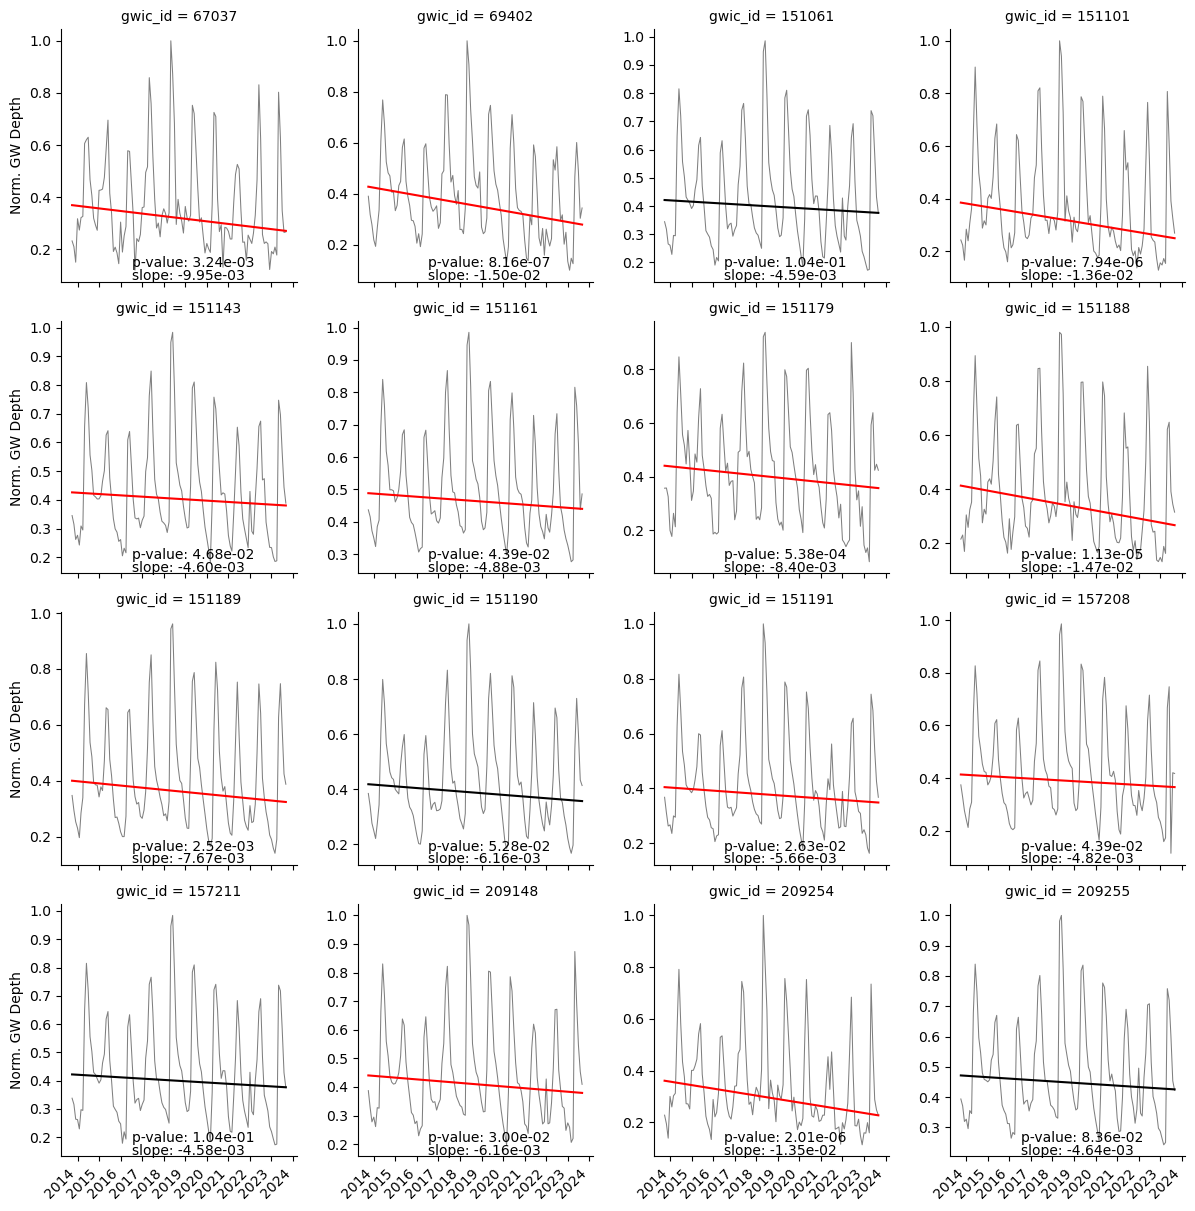

In [17]:
#| label: fig-gw-recent
#| fig-cap: The most recent 10-years of groundwater level data with trends
#|  (significant and non-significant).

rec_mask = (df_norm.index >= '2013-10-01')
df_rec = df_norm.loc[rec_mask]
df_rec = df_rec.drop(columns=['Q', 'pumping_rate', 'gw_avg'])
df_rec_melt = df_rec.reset_index().melt(id_vars='index')
df_rec_melt['time'] = pd.to_datetime(df_rec_melt['index'])
df_rec_melt.drop(columns=['index'], inplace=True)
df_rec_melt.rename(columns={'variable':'gwic_id'}, inplace=True)

# Melt dataframe
df_rec_trend = df_rec_melt.copy()
df_rec_trend['timestamp'] = df_rec_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
rec_trends = df_rec_trend.groupby('gwic_id').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_rec_trend = df_rec_trend.join(rec_trends, on='gwic_id')

# Create the FacetGrid plot
g = sns.FacetGrid(df_rec_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

g.set_ylabels('Norm. GW Depth')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()


In order to understand how withdrawals may be impacting groundwater levels over the entire time period, we remove the normalized trend in river flow from the groundwater signal at all wells (@fig-gw-qremoved). This is, we produce a time series of what ground water depth would look like if the increasing trend of the Clark Fork River flow was removed. This allows us to focus on what the groundwater level would be doing if there was no trend in recharge from the river. With the river flow trend removed, increasing trends in groundwater elevation are reduced in all 16 wells. Five of the 16 lose statistical significance and one shifts from increasing to decreasing; although not statistically significant. This suggests that if the river flows were not increasing over this time period, groundwater trends would not have the same strong increasing trend that we see in the record. Thus, it appears that there is a potential for the river to mask the impact of City pumping rates and that without the increasing streamflow we may see much different behavior in the aquifer water table.

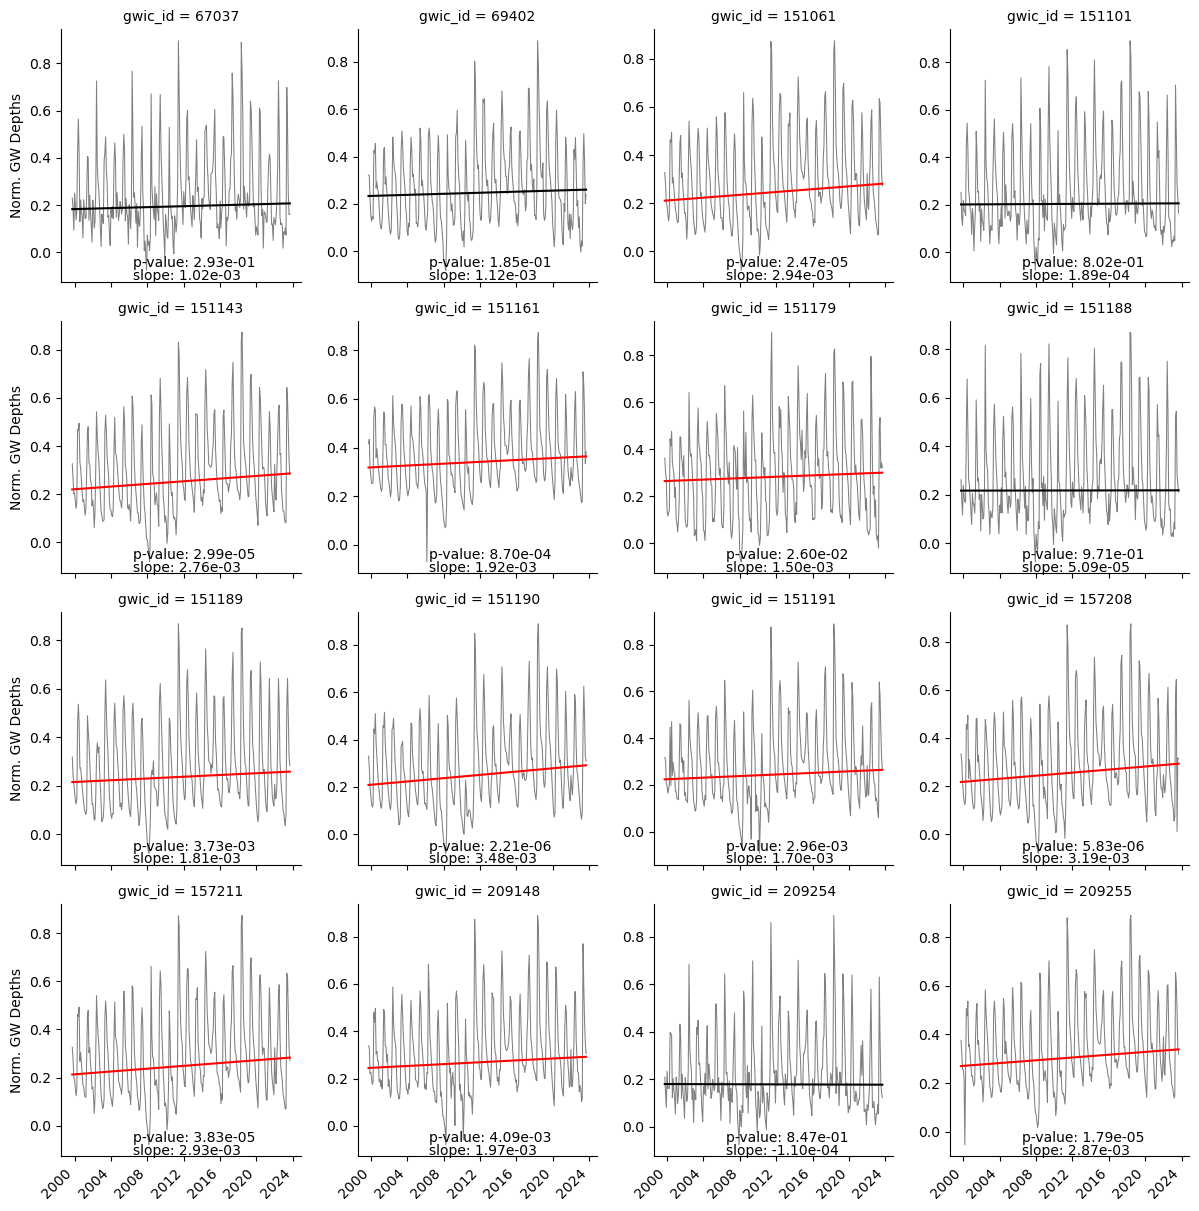

In [15]:
#| label: fig-gw-qremoved
#| fig-cap: Trends in groundwater depth after the normalized Clark Fork River
#|  has been removed. 

# Seasonally decompose and melt
res_q_norm = STL(q_norm, seasonal=25, period=12, robust=True, trend=39).fit()
# res_q_norm = seasonal_decompose(q_norm, period=12)
df_corr = df_norm.drop(columns=['Q', 'pumping_rate', 'gw_avg'])
df_corr = df_corr.sub(res_q_norm.trend, axis=0)

df_corr_melt = df_corr.reset_index().melt(id_vars='index')
df_corr_melt['time'] = pd.to_datetime(df_corr_melt['index'])
df_corr_melt.drop(columns=['index'], inplace=True)
df_corr_melt.rename(columns={'variable': 'gwic_id'}, inplace=True)
df_corr_trend = df_corr_melt.copy()
df_corr_trend['timestamp'] = df_corr_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
corr_trends = df_corr_trend.groupby('gwic_id').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_corr_trend = df_corr_trend.join(corr_trends, on='gwic_id')

# Create the FacetGrid plot
g = sns.FacetGrid(df_corr_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

g.set_ylabels('Norm. GW Depths')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

In reality there is not a single long-term trend in pumping rates, but instead, three short-term trends (@fig-pumping-stl B). The first trend is increasing from 2000 to 2008, the next trend is decreasing from 2009 to 2015, and the last trend is increasing from 2016 to 2023. With the effects from the Clark Fork River trends removed we explore the trends in the average normalized groundwater elevation and pumping rates over these three distinct time periods (@fig-gw-pr-trends). In the first time period (2000-2008) groundwater elevation decreases as pumping rates increase. In the second time period (2009-2015) groundwater elevation increases as pumping rates decrease. And in the third time period (2016-2023) groundwater elevation decreases as pumping rates increase. All trends in both the groundwater and pumping rates are statistically significant. This analysis suggests that City pumping rates can impact the groundwater level in statistically signifacant ways. Therefore, without the recent increase in streamflow, we might be experiencing very different trends in the Missoula Aquifer level. If trends in Clark Fork River flows were to reverse (or even stabilize) and pumping rates were to continue to increase, it is possible that an unstainable condition in the groundwater level could be created.

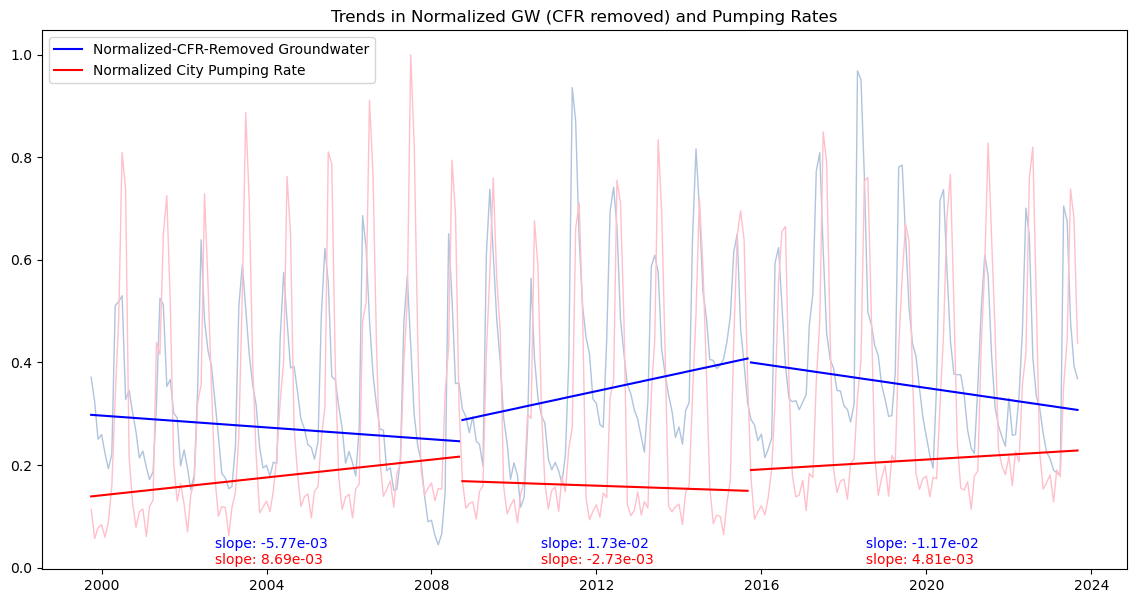

In [20]:
#| label: fig-gw-pr-trends
#| fig-cap: "Trends in normalized average groundwater depth after CFR trend removed 
#|  from the data (i.e. corrected; blue) and trends in normalized Missoula City pumping
#|  rates (red) over three different time periods: (1) 2000--2008, (2) 2009--2015, and 
#|  (3) 2016--2023. These time periods were chosen to correspond with the inflection
#|  points of change illustrated in @fig-pumping-stl. All trends are statistically
#|  significant at the $p<0.05$ level." 

# Calculate trends for time periods
gw_t1 = mk.seasonal_test(df_norm['gw_avg']['1999-10-01':'2008-09-01'].values)
gw_t2 = mk.seasonal_test(df_norm['gw_avg']['2008-10-01':'2015-09-01'].values)
gw_t3 = mk.seasonal_test(df_norm['gw_avg']['2015-10-01':'2023-09-01'].values)

pr_t1 = mk.seasonal_test(df_norm['pumping_rate']['1999-10-01':'2008-09-01'].values)
pr_t2 = mk.seasonal_test(df_norm['pumping_rate']['2008-10-01':'2015-09-01'].values)
pr_t3 = mk.seasonal_test(df_norm['pumping_rate']['2015-10-01':'2023-09-01'].values)

# Plot trends on plot with data
x = df_norm.index
y_gw = df_norm['gw_avg']
y_pr = df_norm['pumping_rate']
slope_gw1 = gw_t1.slope
slope_gw2 = gw_t2.slope
slope_gw3 = gw_t3.slope
intercept_gw1 = gw_t1.intercept
intercept_gw2 = gw_t2.intercept
intercept_gw3 = gw_t3.intercept
slope_pr1 = pr_t1.slope
slope_pr2 = pr_t2.slope
slope_pr3 = pr_t3.slope
intercept_pr1 = pr_t1.intercept
intercept_pr2 = pr_t2.intercept
intercept_pr3 = pr_t3.intercept

# Convert the 'time' column to datetime for plotting
x_datetime = pd.to_datetime(x, unit='s')
x_datetime1 = pd.to_datetime(y_gw['1999-10-01':'2008-09-01'].index, unit='s')
x_datetime2 = pd.to_datetime(y_gw['2008-10-01':'2015-09-01'].index, unit='s')
x_datetime3 = pd.to_datetime(y_gw['2015-10-01':'2023-09-01'].index, unit='s')
x_range1 = np.arange(len(x_datetime1))/12
x_range2 = np.arange(len(x_datetime2))/12
x_range3 = np.arange(len(x_datetime3))/12

# Plot the data
fig, ax = plt.subplots()
plt.plot(x_datetime, y_gw, color='lightsteelblue', linewidth=1)
plt.plot(x_datetime, y_pr, color='pink', linewidth=1)

# Add the slope to the plot
plt.text(0.16, 0.03, f'slope: {slope_pr1:.2e}', ha='left', va='top', transform=plt.gca().transAxes, color='red')
plt.text(0.16, 0.06, f'slope: {slope_gw1:.2e}', ha='left', va='top', transform=plt.gca().transAxes, color='blue')
plt.text(0.46, 0.03, f'slope: {slope_pr2:.2e}', ha='left', va='top', transform=plt.gca().transAxes, color='red')
plt.text(0.46, 0.06, f'slope: {slope_gw2:.2e}', ha='left', va='top', transform=plt.gca().transAxes, color='blue')
plt.text(0.76, 0.03, f'slope: {slope_pr3:.2e}', ha='left', va='top', transform=plt.gca().transAxes, color='red')
plt.text(0.76, 0.06, f'slope: {slope_gw3:.2e}', ha='left', va='top', transform=plt.gca().transAxes, color='blue')

# Plot the trendline
trend_color_pr = 'red'
trend_color_gw = 'blue'
plt.plot(x_datetime1, intercept_gw1 + slope_gw1 * x_range1, color=trend_color_gw, label='Normalized-CFR-Removed Groundwater')
plt.plot(x_datetime2, intercept_gw2 + slope_gw2 * x_range2, color=trend_color_gw)
plt.plot(x_datetime3, intercept_gw3 + slope_gw3 * x_range3, color=trend_color_gw)
plt.plot(x_datetime1, intercept_pr1 + slope_pr1 * x_range1, color=trend_color_pr, label='Normalized City Pumping Rate')
plt.plot(x_datetime2, intercept_pr2 + slope_pr2 * x_range2, color=trend_color_pr)
plt.plot(x_datetime3, intercept_pr3 + slope_pr3 * x_range3, color=trend_color_pr)

plt.legend()
plt.title('Trends in Normalized GW (CFR removed) and Pumping Rates')
fig.set_size_inches(14, 7)
plt.show()

## Summary

We define sustainable aquifer conditions as those in which groundwater depth is either not changing or increasing over time. Over the past 23 years the Missoula Aquifer has been incredibly resilient and even with varying pumping rates all groundwater wells show an overall increasing water table elevation. However, over the most recent 10-years of data, all groundwater levels are decreasing and most of them significantly. This is likely due to the smaller increasing trend in recharge from the river and increasing pumping rates from the City. Additionally, when the trend in the river is removed from the groundwater time series, overall trends in the water table depth are reduced and trends in shorter time periods follow, inversely, the trends in pumping rates. We believe that if population continues to grow and pumping rates increase to match demand, this could present an unsustainable aquifer condition if recharge rates stabilize, or worse decrease. Given these results, we believe that, while the groundwater table has been historically stable over the period of record, the City should not rest on these laurels and should continue to look for ways to mitigate the impacts of increasing population and climate change in the valley. 

In [21]:
#| label: tbl-slopes
#| tbl-cap: 'All groundwater trends color mapped with cool colors representing increasing
#|  trends and warm colors representing decreasing trends. The rows are GWIC IDs and the
#|  columns are as follows: Trend (raw data), 10th % (Lower percentile), 90th % (upper
#|  percentile), Median (50th percentile), Recent (most recent 10 years), and Q removed
#|  (trend after the river flow trend was removed).' 

# m = trends.slope
# m.index = m.index.astype(str)
# m.name = 'Trend'
# m_corr = corr_trends.slope
# m_corr.name = 'Q removed'
# m_rec = rec_trends.slope
# m_rec.name = 'Recent'
# m_qr = df_quantreg.set_index('gwicid')
# m_qr.rename(columns={
#     'quantreg_m1': '10th %',
#     'quantreg_m5': 'Median',
#     'quantreg_m9': '90th %'
#     }, inplace=True)
# df_m = pd.concat([m.to_frame(), m_qr, m_rec, m_corr], axis=1)
# df_m.style.background_gradient('coolwarm_r',
#                                vmin=-0.01,
#                                vmax=0.01,
#                                axis=None)

## References

::: {#refs}
:::